# Part 1: Blob Detection

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

SIFT Tunable Parameters:
nfeatures: Number of best features to retain. Default is 0 (all features are retained). Range: [0, inf)
nOctaveLayers: Number of layers in each octave. Default is 3. Range: [1, 5]
contrastThreshold: Contrast threshold used to filter out weak features. Default is 0.04. Range: [0.01, 0.09]
edgeThreshold: Threshold used to filter out edge-like features. Default is 10. Range: [2, 10]
sigma: Sigma of the Gaussian applied to the input image at the octave #0. Default is 1.6. Range: [1.0, 2.0]
Number of keypoints detected in image 1: 384


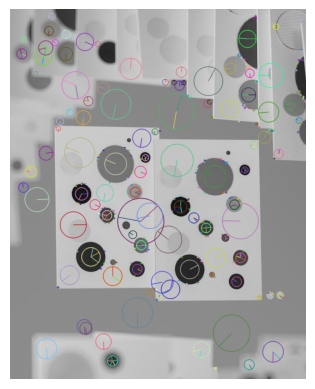

In [2]:
#get the image from file
image1 = cv2.imread('./images/example-image.jpg', cv2.IMREAD_GRAYSCALE)

#initailize the SIFT detector using cv2
sift = cv2.SIFT_create()

#print the tunable parameters of SIFT, description, default values, and appropriate range
#https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html
print("SIFT Tunable Parameters:")
print("nfeatures: Number of best features to retain. Default is 0 (all features are retained). Range: [0, inf)")
print("nOctaveLayers: Number of layers in each octave. Default is 3. Range: [1, 5]")
print("contrastThreshold: Contrast threshold used to filter out weak features. Default is 0.04. Range: [0.01, 0.09]")
print("edgeThreshold: Threshold used to filter out edge-like features. Default is 10. Range: [2, 10]")
print("sigma: Sigma of the Gaussian applied to the input image at the octave #0. Default is 1.6. Range: [1.0, 2.0]")

#use the dector to find keypoints on the input images 
sift = cv2.SIFT_create()
keypoints1 = sift.detect(image1, None)

#use cv2.drawKeypoints to draw the keypoints on the image, ensure drawing flags are set to show the size of the keypoint
output_image1 = cv2.drawKeypoints(image1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#print the number of keypoints detected in each image
print(f"Number of keypoints detected in image 1: {len(keypoints1)}")

# convert BGR (OpenCV default) to RGB for matplotlib
plt.imshow(output_image1, cmap='gray')
plt.axis('off')
plt.show()


# Part 2: Tunning Blob Detection Performance

Obtain the most appropriate set of thresholds to capture as many of the circles in the example image as possible. Only perform this for example-image.

Number of keypoints detected in image 1: 104


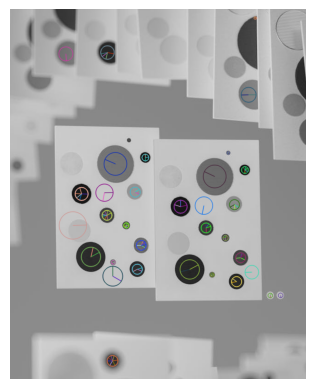

In [3]:
#reinitialize the SIFT detector with different parameters to see their effect
#sift = cv2.SIFT_create(contrastThreshold=0.08, edgeThreshold=3)
sift = cv2.SIFT_create(contrastThreshold=0.09, edgeThreshold=2, nOctaveLayers=5)


#get keypoints again 
keypoints = sift.detect(image1, None)

output_image = cv2.drawKeypoints(image1, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print(f"Number of keypoints detected in image 1: {len(keypoints)}")

plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()



# Part 3: Descriptors 

Select a keypoint and display the image showing the location of the keypoint w/ rectangle for the image patch. 

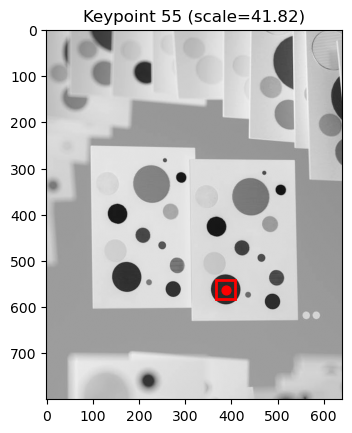

In [4]:
#compute the descriptors for the keypoints
keypoints, descriptors = sift.compute(image1, keypoints)

#select one keypoint and descriptor pair 
kp_idx = 55
kp = keypoints[kp_idx]
desc = descriptors[kp_idx]

#get keypoint properties 
x, y = kp.pt
size = kp.size #corresponds to the scale 

#show image with keypoint adn patch rectangle 
plt.imshow(image1, cmap='gray')
plt.scatter([x], [y], c='r', s=40)

#draw rectangle around the patch (size ~ scale)
rect_size = int(size)
plt.gca().add_patch(plt.Rectangle((x - rect_size/2, y - rect_size/2),
                                  rect_size, rect_size,
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.title(f"Keypoint {kp_idx} (scale={size:.2f})")
plt.show() #display image with keypoint

Explore ways to visualize descriptors with the help of an LLM. 
Acknowledgements: ChatGPT
Visualize the descriptor (as 4x4 grid of 8-bin histograms)

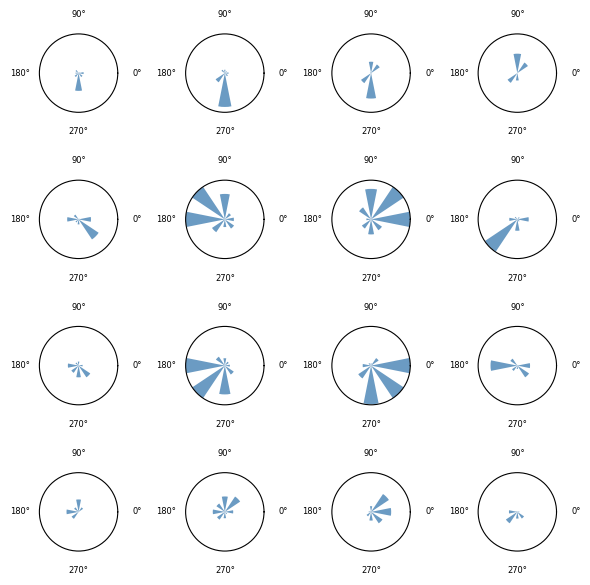

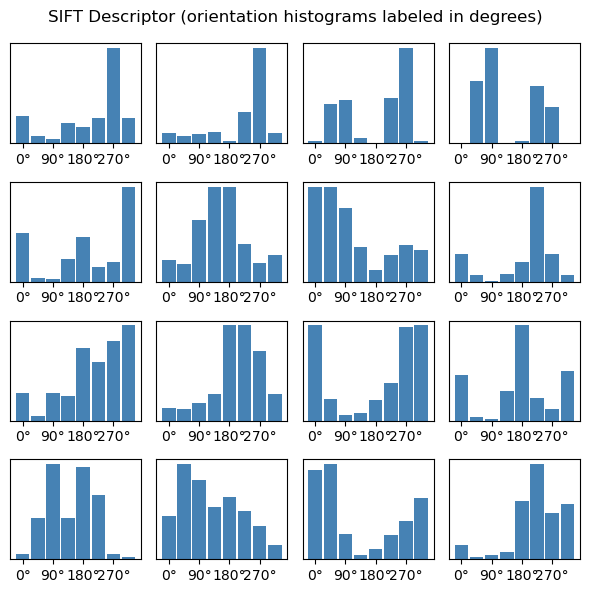

In [5]:
def visualize_descriptor(desc):
    desc = desc.reshape(4, 4, 8)
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    
    # 8 bins correspond to orientations 0°, 45°, 90°, ..., 315°
    angles = np.linspace(0, 360, 9)[:-1]
    
    for i in range(4):
        for j in range(4):
            axes[i, j].bar(angles, desc[i, j], width=40, color='steelblue')
            axes[i, j].set_xticks([0, 90, 180, 270])
            axes[i, j].set_xticklabels(['0°', '90°', '180°', '270°'])
            axes[i, j].set_yticks([])
    
    plt.suptitle("SIFT Descriptor (orientation histograms labeled in degrees)")
    plt.tight_layout()
    plt.show()

def visualize_descriptor_orientations(desc):
    # reshape descriptor into 4x4 grid of 8 orientation bins
    desc = desc.reshape(4, 4, 8)
    fig, axes = plt.subplots(4, 4, figsize=(6, 6), subplot_kw={'projection': 'polar'})
    
    # 8 orientation angles in radians for 0°, 45°, ..., 315°
    angles = np.linspace(0, 2 * np.pi, 9)[:-1]
    degree_labels = ['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°']

    for i in range(4):
        for j in range(4):
            ax = axes[i, j]
            magnitudes = desc[i, j]
            
            # plot bars in polar coordinates
            ax.bar(angles, magnitudes, width=np.pi/8, color='steelblue', alpha=0.8)

            # add minimal degree labels
            ax.set_xticks(np.deg2rad([0, 90, 180, 270]))  # label main axes only
            ax.set_xticklabels(['0°', '90°', '180°', '270°'], fontsize=6)

            # remove radial labels and grid for a cleaner look
            ax.set_yticks([])
            ax.set_ylim(0, np.max(desc))
            ax.grid(False)
    
    plt.tight_layout()
    plt.show()

visualize_descriptor_orientations(desc)

visualize_descriptor(desc)


# Part 4: Feature Matching 

Generate a new image by rotating the original image

In [6]:
#apply rotation to the image, save as a jpg file in the images folder 

rows, cols = image1.shape
M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 45, 1)  # Rotate by 45 degrees
image2 = cv2.warpAffine(image1, M, (cols, rows))

cv2.imwrite('./images/example-image-transformed.jpg', image2)

True

Detect keypoints and compute descriptors for the new image
Use Brute-Force Matcher

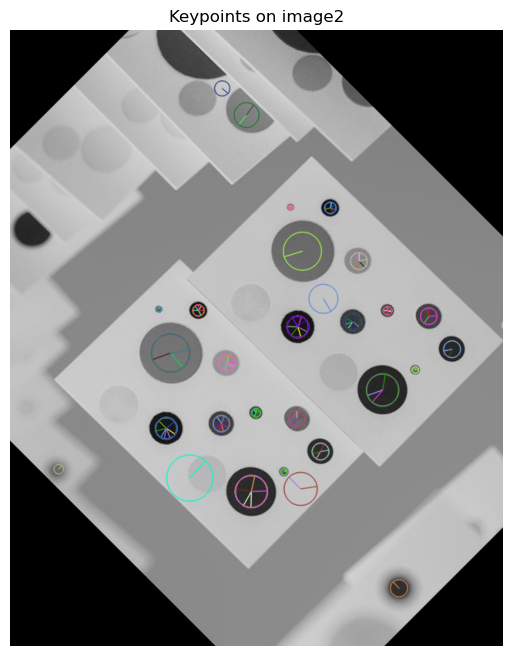

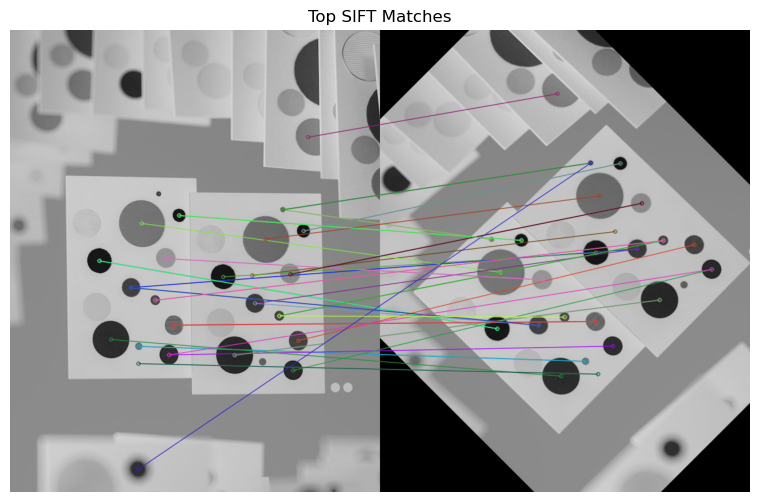

In [7]:
image2 = cv2.imread('./images/example-image-transformed.jpg', cv2.IMREAD_GRAYSCALE)

keypoints2, descriptors2 = sift.detectAndCompute(image2, None) #use the same SIFT detector as part 2

# draw keypoints on image2
image2_kp_vis = cv2.drawKeypoints(
    image2, keypoints2, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(8, 8))
plt.imshow(image2_kp_vis, cmap='gray')
plt.title('Keypoints on image2')
plt.axis('off')
plt.show()

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors, descriptors2)

# sort by distance
matches = sorted(matches, key=lambda x: x.distance)

# draw top 50 matches
matched_img = cv2.drawMatches(
    image1, keypoints,
    image2, keypoints2,
    matches[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# show image
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(matched_img, cmap='gray')
plt.title('Top SIFT Matches')
plt.axis('off')
plt.show()



# Part 5: SIFT Matching with My Own Images

Apply keypoint detection for two images of choice. 



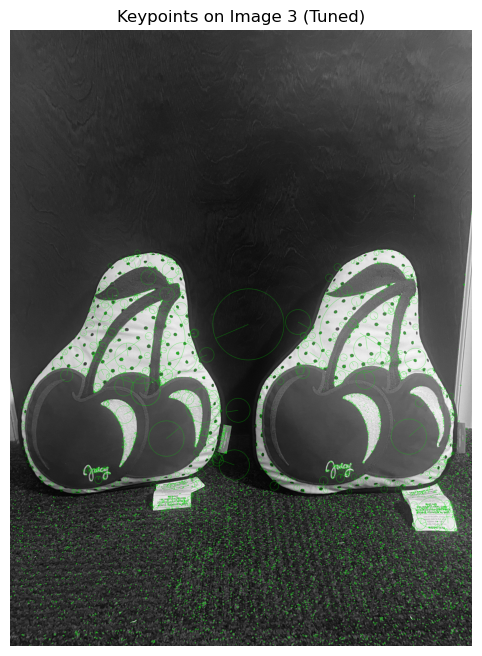

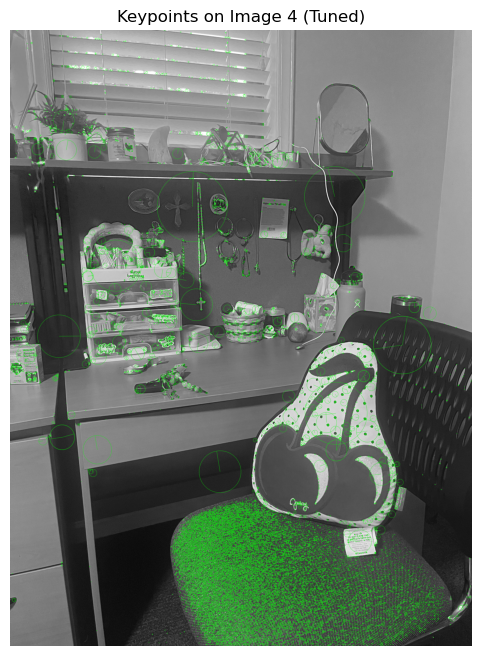

In [31]:

# load both images in grayscale
image3 = cv2.imread('./images/image3.jpeg', cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread('./images/image4.jpeg', cv2.IMREAD_GRAYSCALE)

# create sift detector
sift2 = cv2.SIFT_create(contrastThreshold=0.08, nOctaveLayers=5, sigma=2.0)

# detect and compute
keypointsI3, descriptorsI3 = sift2.detectAndCompute(image3, None)
keypointsI4, descriptorsI4 = sift2.detectAndCompute(image4, None)

# draw keypoints on flower 1
i3_kp_vis = cv2.drawKeypoints(
    image3, keypointsI3, None, color=(0, 225, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(8, 8))
plt.imshow(i3_kp_vis, cmap='gray')
plt.title('Keypoints on Image 3 (Tuned)')
plt.axis('off')
plt.show()

# manually specify color and thickness for keypoints on flower 2
i4_kp_vis = cv2.drawKeypoints(
    image4, keypointsI4, None, color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(8, 8))
plt.imshow(i4_kp_vis, cmap='gray')
plt.title('Keypoints on Image 4 (Tuned)')
plt.axis('off')
plt.show()


Match common features

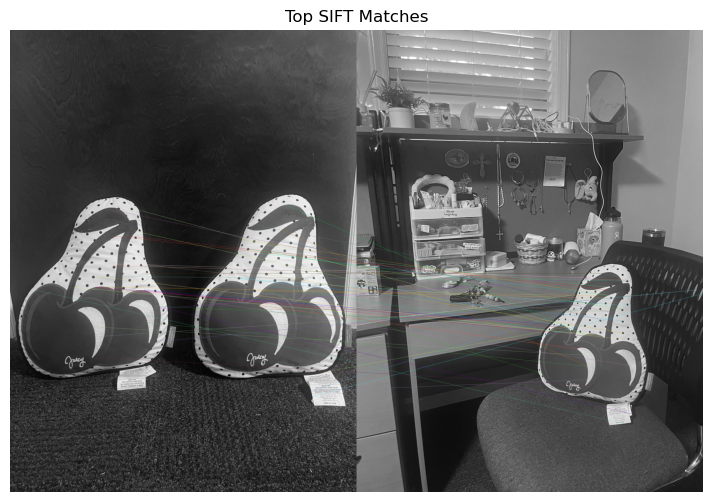

In [32]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches2 = bf.match(descriptorsI3, descriptorsI4)

# sort by distance
matches2 = sorted(matches2, key=lambda x: x.distance)

# draw top 50 matches
matched_img = cv2.drawMatches(
    image3, keypointsI3,
    image4, keypointsI4,
    matches2[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# show image
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.imshow(matched_img)
plt.title('Top SIFT Matches')
plt.axis('off')
plt.show()